In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

df = pd.read_csv("heart_fin.csv")

X = df.drop(columns=["HeartDisease"])
y = df["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

cont_cols = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
binary_cols = ["Sex", "FastingBS", "ExerciseAngina"]

preprocess = ColumnTransformer(
    transformers=[
        ("cont", StandardScaler(), cont_cols),
        ("bin", "passthrough", binary_cols),
    ],
    remainder="passthrough"
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipeline = Pipeline(steps=[("preprocess", preprocess)])

X_train_arr = pipeline.fit_transform(X_train)
X_test_arr = pipeline.transform(X_test)

feature_names = cont_cols + binary_cols
other_cols = [c for c in X_train.columns if c not in cont_cols + binary_cols + ["HeartDisease"]]
feature_names = feature_names + other_cols

X_train_processed = pd.DataFrame(X_train_arr, columns=feature_names, index=X_train.index)
X_test_processed = pd.DataFrame(X_test_arr, columns=feature_names, index=X_test.index)

print("Shape after preprocessing:", X_train_processed.shape)
print("Columns after preprocessing:", X_train_processed.columns.tolist())


Shape after preprocessing: (734, 18)
Columns after preprocessing: ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'Sex', 'FastingBS', 'ExerciseAngina', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

pipelines = {
    "LR":  Pipeline([("prep", preprocess), ("clf", LogisticRegression(max_iter=1000, random_state=42))]),
    "SVC": Pipeline([("prep", preprocess), ("clf", SVC(probability=True, random_state=42))]),
    "RF":  Pipeline([("prep", preprocess), ("clf", RandomForestClassifier(random_state=42))]),
    "XGB": Pipeline([("prep", preprocess), ("clf", XGBClassifier(
        objective="binary:logistic", eval_metric="logloss", random_state=42, n_jobs=-1))]),
    "GBC": Pipeline([("prep", preprocess), ("clf", GradientBoostingClassifier(random_state=42))]),
}


In [3]:
# Logistic Regression
pipe_lr = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

param_lr = {
    "clf__penalty": ["l2"],
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__solver": ["liblinear", "lbfgs"],
    "clf__class_weight": [None, "balanced"],
}

grid_lr = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_lr,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)
grid_lr.fit(X_train, y_train)

print("Best Logistic Regression params:", grid_lr.best_params_)
print("CV ROC-AUC:", grid_lr.best_score_)
y_proba_lr = grid_lr.best_estimator_.predict_proba(X_test)[:, 1]
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba_lr))
print(classification_report(y_test, (y_proba_lr >= 0.5).astype(int)))


Best Logistic Regression params: {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
CV ROC-AUC: 0.9220658534479673
Test ROC-AUC: 0.9317312290769967
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        82
           1       0.90      0.87      0.89       102

    accuracy                           0.88       184
   macro avg       0.87      0.88      0.87       184
weighted avg       0.88      0.88      0.88       184



In [4]:
# SVC
pipe_svc = Pipeline([
    ("prep", preprocess),
    ("clf", SVC(probability=True, random_state=42))
])

param_svc = {
    "clf__kernel": ["rbf", "linear"],
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", "auto"],
    "clf__class_weight": [None, "balanced"],
}

grid_svc = GridSearchCV(
    estimator=pipe_svc,
    param_grid=param_svc,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)
grid_svc.fit(X_train, y_train)

print("Best SVC params:", grid_svc.best_params_)
print("CV ROC-AUC:", grid_svc.best_score_)
y_proba_svc = grid_svc.best_estimator_.predict_proba(X_test)[:, 1]
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba_svc))
print(classification_report(y_test, (y_proba_svc >= 0.5).astype(int)))


Best SVC params: {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}
CV ROC-AUC: 0.9200978305043345
Test ROC-AUC: 0.9365734098517456
              precision    recall  f1-score   support

           0       0.83      0.87      0.85        82
           1       0.89      0.85      0.87       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



In [5]:
# Random Forest
pipe_rf = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(random_state=42))
])

param_rf = {
    "clf__n_estimators": [200, 500],
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__max_features": ["sqrt", "log2"],
}

grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_rf,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)
grid_rf.fit(X_train, y_train)

print("Best RF params:", grid_rf.best_params_)
print("CV ROC-AUC:", grid_rf.best_score_)
y_proba_rf = grid_rf.best_estimator_.predict_proba(X_test)[:, 1]
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print(classification_report(y_test, (y_proba_rf >= 0.5).astype(int)))


Best RF params: {'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 5, 'clf__n_estimators': 500}
CV ROC-AUC: 0.9294038852846441
Test ROC-AUC: 0.922883787661406
              precision    recall  f1-score   support

           0       0.86      0.82      0.84        82
           1       0.86      0.89      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.85      0.86       184
weighted avg       0.86      0.86      0.86       184



In [6]:
# XGBoost
pipe_xgb = Pipeline([
    ("prep", preprocess),
    ("clf", XGBClassifier(
        objective="binary:logistic", eval_metric="logloss", random_state=42, n_jobs=-1
    ))
])

param_xgb = {
    "clf__n_estimators": [200, 500],
    "clf__max_depth": [3, 5, 7],
    "clf__learning_rate": [0.01, 0.1],
    "clf__subsample": [0.8, 1.0],
    "clf__colsample_bytree": [0.8, 1.0],
    "clf__reg_lambda": [1, 5],
}

grid_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_xgb,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)
grid_xgb.fit(X_train, y_train)

print("Best XGB params:", grid_xgb.best_params_)
print("CV ROC-AUC:", grid_xgb.best_score_)
y_proba_xgb = grid_xgb.best_estimator_.predict_proba(X_test)[:, 1]
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))
print(classification_report(y_test, (y_proba_xgb >= 0.5).astype(int)))

import joblib
joblib.dump(grid_xgb.best_estimator_, "xgb_pipeline.pkl")
print("Saved full pipeline as xgb_pipeline.pkl")


Best XGB params: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 500, 'clf__reg_lambda': 5, 'clf__subsample': 0.8}
CV ROC-AUC: 0.9328151643598798
Test ROC-AUC: 0.9318507890961262
              precision    recall  f1-score   support

           0       0.90      0.84      0.87        82
           1       0.88      0.92      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184

Saved full pipeline as xgb_pipeline.pkl


In [7]:
import xgboost
print(xgboost.__version__)


1.7.6


In [8]:
import shap

best_model = grid_xgb.best_estimator_
xgb_final = best_model.named_steps["clf"]
X_test_transformed = best_model.named_steps["prep"].transform(X_test)

try:
    feature_names = best_model.named_steps["prep"].get_feature_names_out()
    feature_names = [f.split("__")[-1] for f in feature_names]
except:
    feature_names = cont_cols + binary_cols

# ⚙️ Fix base_score lỗi format trong booster
booster = xgb_final.get_booster()
attrs = booster.attributes()

if "base_score" in attrs:
    try:
        base_score = float(attrs["base_score"].replace("{", "").replace("}", ""))
        booster.set_attr(base_score=str(base_score))
        print(f"✅ base_score fixed: {base_score}")
    except Exception as e:
        print("⚠️ base_score not fixed:", attrs["base_score"], e)

# ✅ Tạo TreeExplainer trực tiếp từ booster thay vì từ XGBClassifier
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test_transformed)

print("✅ SHAP values shape:", shap_values.shape)
print("✅ Feature names length:", len(feature_names))


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


✅ SHAP values shape: (184, 18)
✅ Feature names length: 18


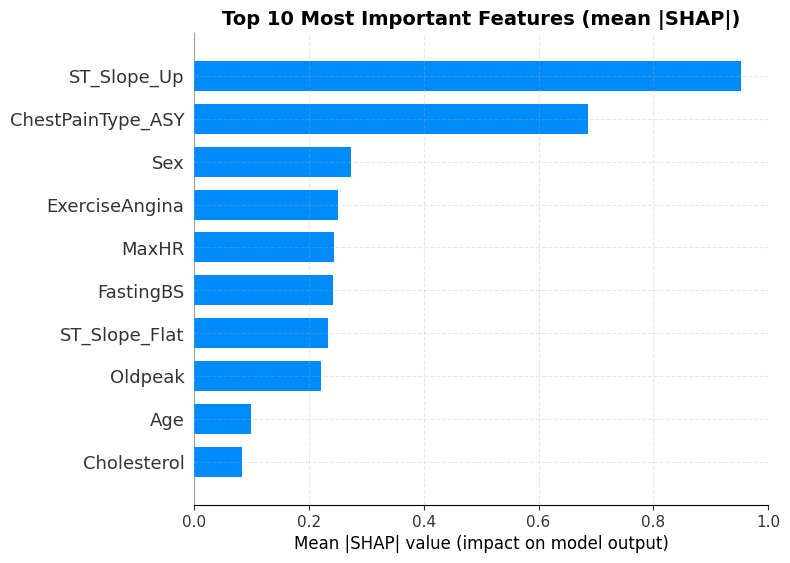

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6)) 
shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=feature_names,
    plot_type="bar",
    max_display=10, 
    show=False
)
plt.title("Top 10 Most Important Features (mean |SHAP|)", fontsize=14, fontweight="bold")
plt.xlabel("Mean |SHAP| value (impact on model output)", fontsize=12)
plt.grid(alpha=0.3, linestyle="--")
plt.savefig("shap1.png", bbox_inches='tight')
plt.show()


In [10]:
from sklearn.inspection import permutation_importance

best_model = grid_xgb.best_estimator_

X_test_transformed = best_model.named_steps["prep"].transform(X_test)

result = permutation_importance(
    best_model, X_test, y_test, 
    n_repeats=30, 
    random_state=42, 
    scoring="roc_auc"
)

import pandas as pd
perm_importance = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values(by="importance_mean", ascending=False)

print(perm_importance.head(10))


              feature  importance_mean  importance_std
17        ST_Slope_Up         0.056767        0.013419
8   ChestPainType_ASY         0.029830        0.011172
1                 Sex         0.019460        0.006459
7             Oldpeak         0.015363        0.006941
4           FastingBS         0.011661        0.004057
6      ExerciseAngina         0.007353        0.004112
5               MaxHR         0.005974        0.006084
2           RestingBP         0.004224        0.002123
16      ST_Slope_Flat         0.003706        0.003629
3         Cholesterol         0.002738        0.001526


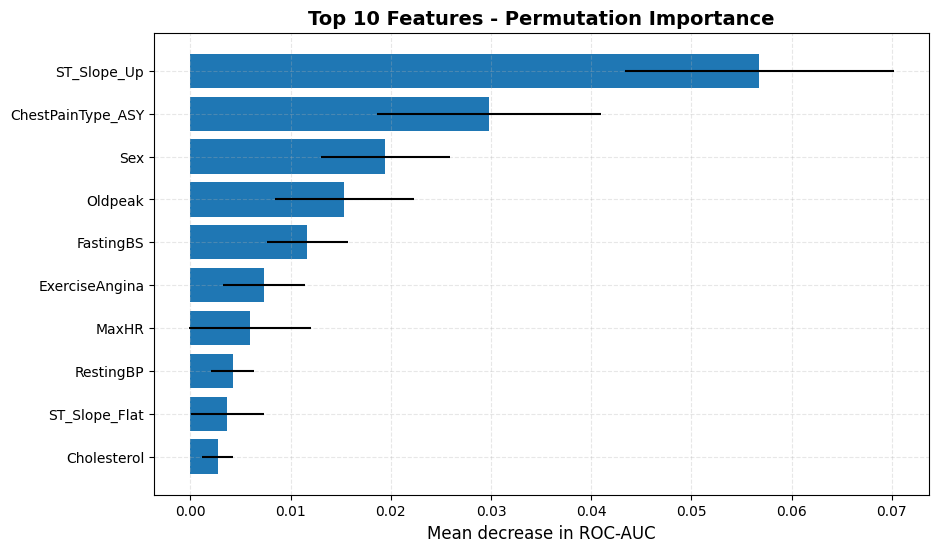

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(
    perm_importance["feature"][:10][::-1],
    perm_importance["importance_mean"][:10][::-1],
    xerr=perm_importance["importance_std"][:10][::-1],
    color="#1f77b4"
)
plt.xlabel("Mean decrease in ROC-AUC", fontsize=12)
plt.title("Top 10 Features - Permutation Importance", fontsize=14, fontweight="bold")
plt.grid(alpha=0.3, linestyle="--")
plt.savefig("perm1.png", bbox_inches="tight")
plt.show()
